In [1]:
from fbpinns.problems import Problem
import jax.numpy as jnp
import jax
import numpy as np

In [2]:
from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN, StackedChebyshevKAN, StackedLegendreKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer
from fbpinns.problems import WaveEquation2D

subdomain_xs=[np.linspace(0,1,3), np.linspace(0,1,3)]
c = Constants(
    domain=RectangularDomainND,
    domain_init_kwargs = dict(
        xmin=np.array([0.,0.]),
        xmax=np.array([1.,1.])
        ),
    problem=WaveEquation2D,
    problem_init_kwargs = dict(
        # c=2
    ),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 1.2),
        unnorm=(0.,5.),
    ),
    network=StackedChebyshevKAN,
    network_init_kwargs = dict(
        dims=[2, 1],
        degrees=[16]
    ),
    optimiser_kwargs = dict(
        learning_rate=0.001
        ),
    ns=((200,200),),
    n_test=(200,200),
    n_steps=30000,
    clear_output=False,
    attention_tracking_kwargs=dict(
        eta_lr = 1e-2,
        gamma_decay = 0.99,
        out_dim=1,
        N=40000
        ),
    )

# run = FBPINNTrainer(c)
# all_params = run.train()

In [3]:
# all_params_ = all_params
# all_params = all_params_[0]

In [4]:
import pickle
import numpy as np
import jax
import jax.numpy as jnp

def load_model(path):
    # 1) Un-pickle to get your pytree of numpy ndarrays (and other objects)
    with open(path, "rb") as f:
        model = pickle.load(f)

    # 2) Convert any numpy arrays back into JAX arrays
    model = jax.tree_map(
        lambda x: jnp.array(x) if isinstance(x, np.ndarray) else x,
        model
    )
    return model

# usage
n, all_params, all_opt_states, active, u_test_losses = load_model("/vol/bitbucket/ss7921/FBPINNs/benchmarks/notebooks/results/model_00030000.jax")

In [76]:
import matplotlib.pyplot as plt

def plot_sch(data_list, noshow=False, ax=None):
    # Example: generating some data of shape (2, 200, 200) (real and imaginary)
    data = data_list
    n_fields, Ny, Nx = data.shape
    y = np.arange(Ny)
    x = np.arange(Nx)
    X, Y = np.meshgrid(x, y)
    
    titles = ['wave']  # extend or truncate as needed

    if noshow and ax is None:
        raise ValueError("If noshow is True, a axis must be provided.")

    # create one tall figure with n_fields rows
    if not noshow:
        fig = plt.figure(figsize=(8, 4 * n_fields))
    for i in range(n_fields):
        if not noshow:
            ax = fig.add_subplot(n_fields, 1, i+1, projection='3d')
            
        # 100 levels; use ax.contour3D (alias for Axes3D.contour)
        cont = ax.plot_surface(X, Y, data[i], cmap='viridis')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('value')
        ax.set_title(titles[i] if i < len(titles) else f'field {i}')
        
    if not noshow:
        plt.tight_layout()
        plt.show()

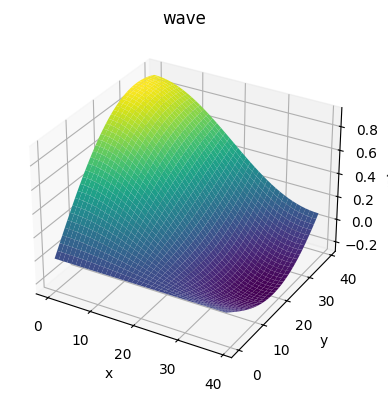

In [77]:
with open('/vol/bitbucket/ss7921/FBPINNs/benchmarks/runs/Wave/CKAN_8/test_exact.npy', 'rb') as f:
    exact_wave = np.load(f).reshape(200, 200, -1)
plot_sch(exact_wave[:40, :40, :].transpose(2, 0, 1))

In [7]:
from fbpinns.trainers import get_inputs, _common_train_initialisation
from jax import random

(optimiser, all_opt_states, optimiser_fn, loss_fn, key,
        constraints_global, x_batch_global, constraint_offsets_global, constraint_fs_global, jmapss,
        x_batch_test, u_exact) = _common_train_initialisation(c, random.PRNGKey(c.seed), all_params, problem=WaveEquation2D, domain=RectangularDomainND)

active_test_ = jnp.ones(all_params["static"]["decomposition"]["m"], dtype=int)

takes_, all_ims_, (_, _, _, cut_all_, _)  = get_inputs(x_batch_test, active_test_, all_params, RectangularDecompositionND)

test_inputs = (takes_, all_ims_, cut_all_)

takes = takes_
m_take, n_take, p_take, np_take, npou = takes

[INFO] 2025-06-03 21:05:00 - Total number of trainable parameters:
[INFO] 2025-06-03 21:05:00 - 	attention: 40,000
[INFO] 2025-06-03 21:05:00 - 	network: 648
[INFO] 2025-06-03 21:05:00 - 	problem: 40,001


[INFO] 2025-06-03 21:05:01 - Total number of constraints: 1
[INFO] 2025-06-03 21:05:01 - Computing exact solution..
[INFO] 2025-06-03 21:05:02 - Computing done


In [8]:
# all_params_cut = {"static":cut_all_(all_params["static"]),
#                 "trainable":cut_all_(all_params["trainable"])}

# d = all_params_cut
# all_params_take = {t_k: {cl_k: {k: jax.tree_map(lambda p:p[m_take], d[t_k][cl_k][k]) if k=="subdomain" else d[t_k][cl_k][k]
#         for k in d[t_k][cl_k]}
#         for cl_k in d[t_k]}
#         for t_k in ["static", "trainable"]}
# f = {t_k: {cl_k: {k: jax.tree_map(lambda p: 0, d[t_k][cl_k][k]) if k=="subdomain" else jax.tree_map(lambda p: None, d[t_k][cl_k][k])
#         for k in d[t_k][cl_k]}
#         for cl_k in d[t_k]}
#         for t_k in ["static", "trainable"]}

In [9]:
# from functools import partial

x_take = x_batch_test[n_take]
# us, ws, uraw = vmap(foo, in_axes=(f,0,None, None, None, None))(all_params_take, x_take, 
#                                                                norm_fn, 
#                                                                StackedChebyshevKAN.network_fn, 
#                                                                unnorm_fn, 
#                                                                window)
# us.shape, ws.shape, uraw.shape

In [45]:
decomp = RectangularDecompositionND
from jax import vmap
import fbpinns.windows as windows

def norm_fn(params, x):
    xmin, xmax = params["static"]["decomposition"]["subdomain"]["params"][:2]
    mu, sd = (xmax+xmin)/2, (xmax-xmin)/2
    print('norm', mu, sd)
    # return x
    return (x-jnp.zeros_like(mu))/jnp.ones_like(sd)

def unnorm_fn(params, u):
    params = params["static"]["decomposition"]["subdomain"]["params"]
    mu, sd = params[5]
    print('unnorm', mu, sd)
    # return u
    return (u-jnp.zeros_like(mu))/jnp.ones_like(sd)

def net(params, x, model_i=4):
    layer1 = params['trainable']['network']['subdomain']['coeffs_list'][0][model_i]
    layer2 = params['trainable']['network']['subdomain']['coeffs_list'][1][model_i]

    o = x
    o = ChebyshevKAN.forward(coeffs=layer1, kind=2, x=o)
    o = ChebyshevKAN.forward(coeffs=layer2, kind=2, x=o)
    return o

def window(params, x):
    print(x.shape)
    params = params["static"]["decomposition"]["subdomain"]["params"]
    a = params[4]*windows.cosine(*params[:2], x)+(1-params[4])
    # print(a.shape)
    return jnp.ones_like(a)
    # return a

def foo(params, x, norm, network_fn, unnorm, window_fn):
    normed = norm(params, x)
    uraw = network_fn(params, normed)
    unnormed = unnorm(params, uraw)
    w = window_fn(params, x)
    return unnormed*w, w, uraw


In [53]:
def models_infr(models, degrees=(0,6), dims=(0, 4)):
    _, all_params, _, _, _ = load_model("/vol/bitbucket/ss7921/FBPINNs/benchmarks/notebooks/results/model_00030000.jax")

    a, b = all_params['trainable']['network']['subdomain']['coeffs_list']
    ka, kb = all_params['static']['network']['subdomain']['kinds']

    start_deg, end_deg = degrees
    start_dim, end_dim = dims

    c, d = a[models, :, start_dim:end_dim, start_deg:end_deg], b[models, start_dim:end_dim, :, start_deg:end_deg]
    kc, kd = ka[models,], kb[models,]
    print(a.shape, c.shape, kc, kd)
    print('c', c, 'd', d)

    changed_params = all_params.copy()
    changed_params['trainable']['network']['subdomain']['coeffs_list'] = (c, d)
    changed_params['static']['network']['subdomain']['kinds'] = (kc, kd)


    changed_params_cut = {"static":cut_all_(changed_params["static"]),
                    "trainable":cut_all_(changed_params["trainable"])}

    d = changed_params_cut
    changed_params_take = {t_k: {cl_k: {k: jax.tree_map(lambda p:p[m_take], d[t_k][cl_k][k]) if k=="subdomain" else d[t_k][cl_k][k]
            for k in d[t_k][cl_k]}
            for cl_k in d[t_k]}
            for t_k in ["static", "trainable"]}
    f = {t_k: {cl_k: {k: jax.tree_map(lambda p: 0, d[t_k][cl_k][k]) if k=="subdomain" else jax.tree_map(lambda p: None, d[t_k][cl_k][k])
            for k in d[t_k][cl_k]}
            for cl_k in d[t_k]}
            for t_k in ["static", "trainable"]}

    us, ws, uraw = vmap(foo, in_axes=(f,0,None, None, None, None))(changed_params_take, x_take, 
                                                                RectangularDecompositionND.norm_fn, 
                                                                StackedChebyshevKAN.network_fn, 
                                                                RectangularDecompositionND.unnorm_fn, 
                                                                RectangularDecompositionND.window_fn)

    u = jnp.concatenate([us, ws], axis=1)
    u = jax.ops.segment_sum(u, p_take, indices_are_sorted=False, num_segments=len(np_take))
    wp = u[:,-1:]
    u = u[:,:-1]/wp
    u = jax.ops.segment_sum(u, np_take, indices_are_sorted=False, num_segments=len(x_batch_test))
    u = u/npou
    u = WaveEquation2D.constraining_fn(all_params, x_batch_test, u)
    return u

models_infr([0], degrees=(0, 1)).shape

(9, 2, 4, 6) (1, 2, 4, 1) [2] [2]
c [[[[-0.0699448 ]
   [ 0.02293275]
   [ 0.04919959]
   [ 0.01719464]]

  [[-0.20932725]
   [-0.02539442]
   [ 0.21853288]
   [-0.05313112]]]] d [[[[-0.8505256 ]]

  [[-0.7837597 ]]

  [[-0.73374605]]

  [[-0.8171512 ]]]]


(40000, 1)

(9, 2, 4, 6) (1, 2, 4, 6) [2] [2]
c [[[[-0.0699448  -0.11957631 -0.29860216 -0.11568612 -0.0546978
    -0.03104024]
   [ 0.02293275  0.16836119  0.31022173  0.18817611 -0.03811791
     0.0727372 ]
   [ 0.04919959 -0.09103608 -0.30091816 -0.18951927  0.04036855
    -0.09546851]
   [ 0.01719464  0.17916398  0.13664919  0.03199784  0.13729925
    -0.04029236]]

  [[-0.20932725 -0.05121543  0.17945825 -0.097971   -0.04495228
    -0.1333692 ]
   [-0.02539442  0.02646047 -0.0542903  -0.03326709 -0.05862406
     0.18162206]
   [ 0.21853288  0.01045209 -0.00503394 -0.0742318   0.06421527
     0.07485833]
   [-0.05313112  0.08186758 -0.07705869 -0.4733061   0.0127183
    -0.3042013 ]]]] d [[[[-0.8505256   1.6566033   0.40806547 -1.5784588   0.7751971
     0.8275765 ]]

  [[-0.7837597   0.72082114  0.9227103  -0.70050293 -1.4402223
     0.5142672 ]]

  [[-0.73374605 -2.8984292  -0.3346484   1.9562883   1.4077096
     0.37223792]]

  [[-0.8171512   0.7060524   1.2874671  -0.94813466 -0.9911314
  

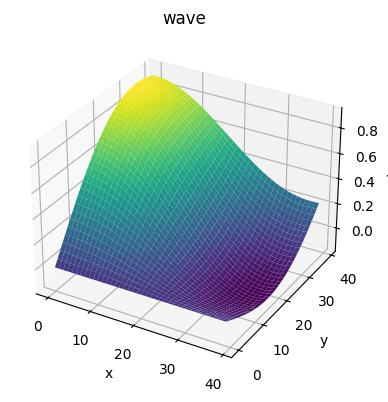

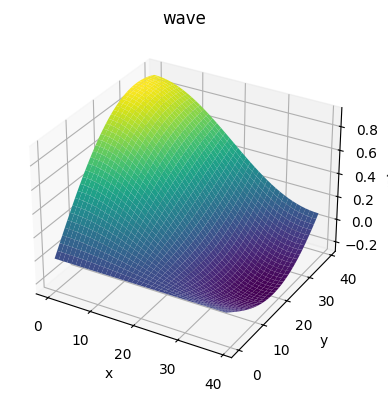

In [78]:
plot_sch(models_infr([0]).reshape(200, 200, 1)[:40, :40, :].transpose(2, 0, 1))
plot_sch(exact_wave[:40, :40, :].transpose(2, 0, 1))

(9, 2, 4, 6) (1, 2, 4, 1) [2] [2]
c [[[[-0.0699448 ]
   [ 0.02293275]
   [ 0.04919959]
   [ 0.01719464]]

  [[-0.20932725]
   [-0.02539442]
   [ 0.21853288]
   [-0.05313112]]]] d [[[[-0.8505256 ]]

  [[-0.7837597 ]]

  [[-0.73374605]]

  [[-0.8171512 ]]]]
norm Traced<ShapedArray(float32[2])>with<BatchTrace> with
  val = Array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]], dtype=float32)
  batch_dim = 0 Traced<ShapedArray(float32[2])>with<BatchTrace> with
  val = Array([[0.3       , 0.3       ],
       [0.3       , 0.3       ],
       [0.3       , 0.3       ],
       ...,
       [0.29999998, 0.29999998],
       [0.29999998, 0.29999998],
       [0.29999998, 0.29999998]], dtype=float32)
  batch_dim = 0


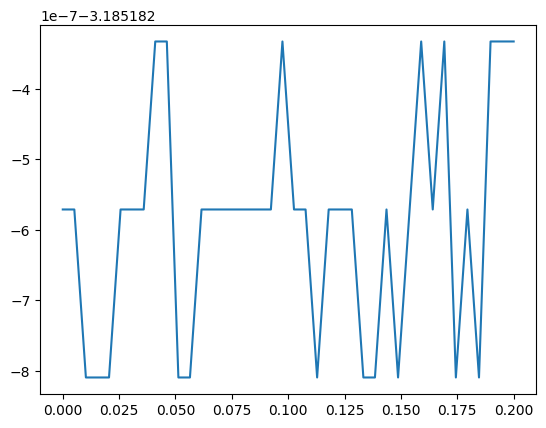

(9, 2, 4, 6) (1, 2, 4, 2) [2] [2]
c [[[[-0.0699448  -0.11957631]
   [ 0.02293275  0.16836119]
   [ 0.04919959 -0.09103608]
   [ 0.01719464  0.17916398]]

  [[-0.20932725 -0.05121543]
   [-0.02539442  0.02646047]
   [ 0.21853288  0.01045209]
   [-0.05313112  0.08186758]]]] d [[[[-0.8505256   1.6566033 ]]

  [[-0.7837597   0.72082114]]

  [[-0.73374605 -2.8984292 ]]

  [[-0.8171512   0.7060524 ]]]]
norm Traced<ShapedArray(float32[2])>with<BatchTrace> with
  val = Array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]], dtype=float32)
  batch_dim = 0 Traced<ShapedArray(float32[2])>with<BatchTrace> with
  val = Array([[0.3       , 0.3       ],
       [0.3       , 0.3       ],
       [0.3       , 0.3       ],
       ...,
       [0.29999998, 0.29999998],
       [0.29999998, 0.29999998],
       [0.29999998, 0.29999998]], dtype=float32)
  batch_dim = 0


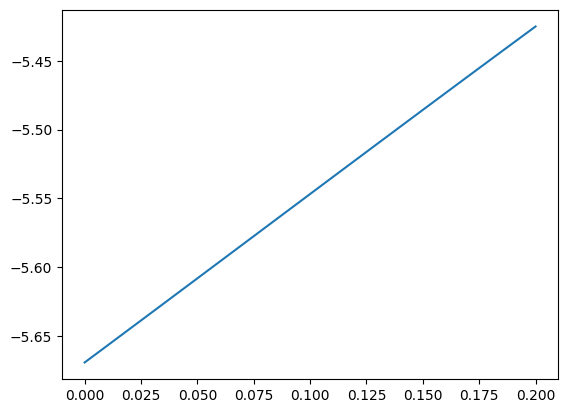

(9, 2, 4, 6) (1, 2, 4, 3) [2] [2]
c [[[[-0.0699448  -0.11957631 -0.29860216]
   [ 0.02293275  0.16836119  0.31022173]
   [ 0.04919959 -0.09103608 -0.30091816]
   [ 0.01719464  0.17916398  0.13664919]]

  [[-0.20932725 -0.05121543  0.17945825]
   [-0.02539442  0.02646047 -0.0542903 ]
   [ 0.21853288  0.01045209 -0.00503394]
   [-0.05313112  0.08186758 -0.07705869]]]] d [[[[-0.8505256   1.6566033   0.40806547]]

  [[-0.7837597   0.72082114  0.9227103 ]]

  [[-0.73374605 -2.8984292  -0.3346484 ]]

  [[-0.8171512   0.7060524   1.2874671 ]]]]
norm Traced<ShapedArray(float32[2])>with<BatchTrace> with
  val = Array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]], dtype=float32)
  batch_dim = 0 Traced<ShapedArray(float32[2])>with<BatchTrace> with
  val = Array([[0.3       , 0.3       ],
       [0.3       , 0.3       ],
       [0.3       , 0.3       ],
       ...,
       [0.29999998, 0.29999998],
       [0.29999998, 0.29999998],
      

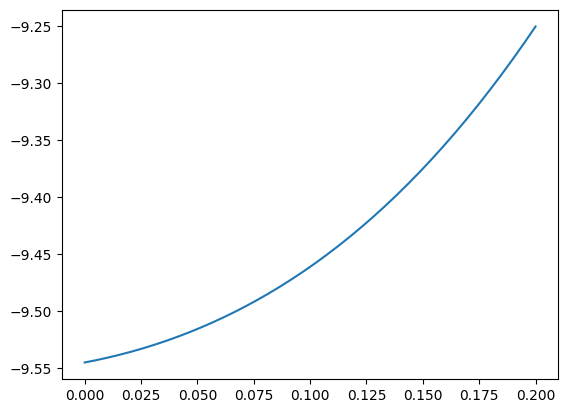

(9, 2, 4, 6) (1, 2, 4, 4) [2] [2]
c [[[[-0.0699448  -0.11957631 -0.29860216 -0.11568612]
   [ 0.02293275  0.16836119  0.31022173  0.18817611]
   [ 0.04919959 -0.09103608 -0.30091816 -0.18951927]
   [ 0.01719464  0.17916398  0.13664919  0.03199784]]

  [[-0.20932725 -0.05121543  0.17945825 -0.097971  ]
   [-0.02539442  0.02646047 -0.0542903  -0.03326709]
   [ 0.21853288  0.01045209 -0.00503394 -0.0742318 ]
   [-0.05313112  0.08186758 -0.07705869 -0.4733061 ]]]] d [[[[-0.8505256   1.6566033   0.40806547 -1.5784588 ]]

  [[-0.7837597   0.72082114  0.9227103  -0.70050293]]

  [[-0.73374605 -2.8984292  -0.3346484   1.9562883 ]]

  [[-0.8171512   0.7060524   1.2874671  -0.94813466]]]]
norm Traced<ShapedArray(float32[2])>with<BatchTrace> with
  val = Array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]], dtype=float32)
  batch_dim = 0 Traced<ShapedArray(float32[2])>with<BatchTrace> with
  val = Array([[0.3       , 0.3       ],
      

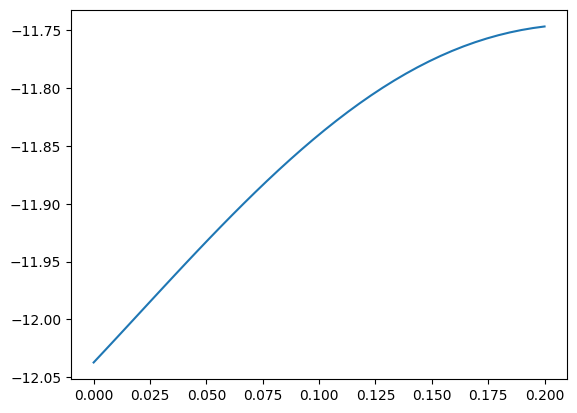

(9, 2, 4, 6) (1, 2, 4, 5) [2] [2]
c [[[[-0.0699448  -0.11957631 -0.29860216 -0.11568612 -0.0546978 ]
   [ 0.02293275  0.16836119  0.31022173  0.18817611 -0.03811791]
   [ 0.04919959 -0.09103608 -0.30091816 -0.18951927  0.04036855]
   [ 0.01719464  0.17916398  0.13664919  0.03199784  0.13729925]]

  [[-0.20932725 -0.05121543  0.17945825 -0.097971   -0.04495228]
   [-0.02539442  0.02646047 -0.0542903  -0.03326709 -0.05862406]
   [ 0.21853288  0.01045209 -0.00503394 -0.0742318   0.06421527]
   [-0.05313112  0.08186758 -0.07705869 -0.4733061   0.0127183 ]]]] d [[[[-0.8505256   1.6566033   0.40806547 -1.5784588   0.7751971 ]]

  [[-0.7837597   0.72082114  0.9227103  -0.70050293 -1.4402223 ]]

  [[-0.73374605 -2.8984292  -0.3346484   1.9562883   1.4077096 ]]

  [[-0.8171512   0.7060524   1.2874671  -0.94813466 -0.9911314 ]]]]
norm Traced<ShapedArray(float32[2])>with<BatchTrace> with
  val = Array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [1., 1.],
       [1., 1.],
     

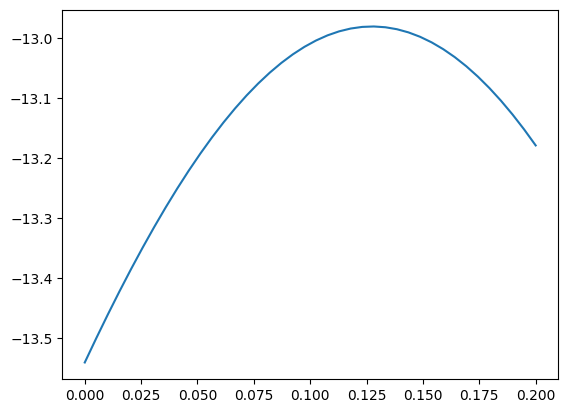

(9, 2, 4, 6) (1, 2, 4, 6) [2] [2]
c [[[[-0.0699448  -0.11957631 -0.29860216 -0.11568612 -0.0546978
    -0.03104024]
   [ 0.02293275  0.16836119  0.31022173  0.18817611 -0.03811791
     0.0727372 ]
   [ 0.04919959 -0.09103608 -0.30091816 -0.18951927  0.04036855
    -0.09546851]
   [ 0.01719464  0.17916398  0.13664919  0.03199784  0.13729925
    -0.04029236]]

  [[-0.20932725 -0.05121543  0.17945825 -0.097971   -0.04495228
    -0.1333692 ]
   [-0.02539442  0.02646047 -0.0542903  -0.03326709 -0.05862406
     0.18162206]
   [ 0.21853288  0.01045209 -0.00503394 -0.0742318   0.06421527
     0.07485833]
   [-0.05313112  0.08186758 -0.07705869 -0.4733061   0.0127183
    -0.3042013 ]]]] d [[[[-0.8505256   1.6566033   0.40806547 -1.5784588   0.7751971
     0.8275765 ]]

  [[-0.7837597   0.72082114  0.9227103  -0.70050293 -1.4402223
     0.5142672 ]]

  [[-0.73374605 -2.8984292  -0.3346484   1.9562883   1.4077096
     0.37223792]]

  [[-0.8171512   0.7060524   1.2874671  -0.94813466 -0.9911314
  

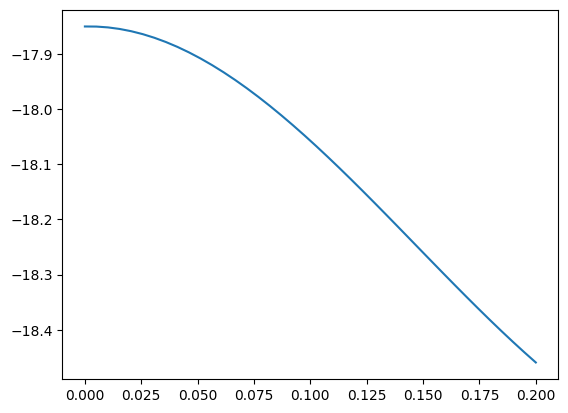

In [13]:
for i in range(6):
    m = models_infr([0], degrees=(0, i+1)).reshape(200, 200, 1)[:40, 20, :]
    plt.plot(np.linspace(0, 1, 40)*0.2, m)
    plt.show()

(9, 2, 4, 6) (1, 2, 4, 6) [2] [2]
c [[[[-0.0699448  -0.11957631 -0.29860216 -0.11568612 -0.0546978
    -0.03104024]
   [ 0.02293275  0.16836119  0.31022173  0.18817611 -0.03811791
     0.0727372 ]
   [ 0.04919959 -0.09103608 -0.30091816 -0.18951927  0.04036855
    -0.09546851]
   [ 0.01719464  0.17916398  0.13664919  0.03199784  0.13729925
    -0.04029236]]

  [[-0.20932725 -0.05121543  0.17945825 -0.097971   -0.04495228
    -0.1333692 ]
   [-0.02539442  0.02646047 -0.0542903  -0.03326709 -0.05862406
     0.18162206]
   [ 0.21853288  0.01045209 -0.00503394 -0.0742318   0.06421527
     0.07485833]
   [-0.05313112  0.08186758 -0.07705869 -0.4733061   0.0127183
    -0.3042013 ]]]] d [[[[-0.8505256   1.6566033   0.40806547 -1.5784588   0.7751971
     0.8275765 ]]

  [[-0.7837597   0.72082114  0.9227103  -0.70050293 -1.4402223
     0.5142672 ]]

  [[-0.73374605 -2.8984292  -0.3346484   1.9562883   1.4077096
     0.37223792]]

  [[-0.8171512   0.7060524   1.2874671  -0.94813466 -0.9911314
  

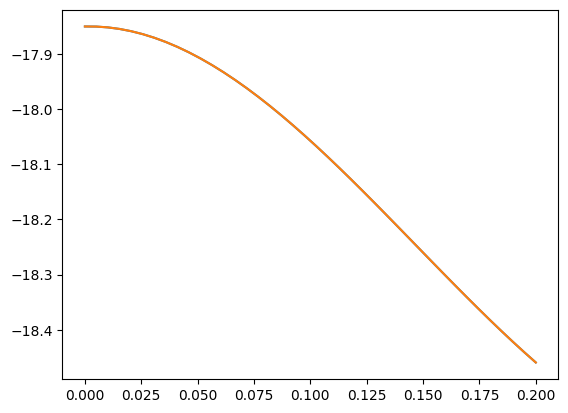

In [14]:
m = models_infr([0]).reshape(200, 200, 1)[:40, 20, 0]
xs = np.linspace(0, 1, 40)*0.2
poly = np.polyfit(xs, m, 5)
f = np.poly1d(poly)
print('\n', poly, f)
plt.plot(xs, m, label='data')
plt.plot(xs, f(xs), label='polyfit')

(9, 2, 4, 6) (1, 2, 4, 6) [2] [2]
c [[[[-0.0699448  -0.11957631 -0.29860216 -0.11568612 -0.0546978
    -0.03104024]
   [ 0.02293275  0.16836119  0.31022173  0.18817611 -0.03811791
     0.0727372 ]
   [ 0.04919959 -0.09103608 -0.30091816 -0.18951927  0.04036855
    -0.09546851]
   [ 0.01719464  0.17916398  0.13664919  0.03199784  0.13729925
    -0.04029236]]

  [[-0.20932725 -0.05121543  0.17945825 -0.097971   -0.04495228
    -0.1333692 ]
   [-0.02539442  0.02646047 -0.0542903  -0.03326709 -0.05862406
     0.18162206]
   [ 0.21853288  0.01045209 -0.00503394 -0.0742318   0.06421527
     0.07485833]
   [-0.05313112  0.08186758 -0.07705869 -0.4733061   0.0127183
    -0.3042013 ]]]] d [[[[-0.8505256   1.6566033   0.40806547 -1.5784588   0.7751971
     0.8275765 ]]

  [[-0.7837597   0.72082114  0.9227103  -0.70050293 -1.4402223
     0.5142672 ]]

  [[-0.73374605 -2.8984292  -0.3346484   1.9562883   1.4077096
     0.37223792]]

  [[-0.8171512   0.7060524   1.2874671  -0.94813466 -0.9911314
  

norm Traced<ShapedArray(float32[2])>with<BatchTrace> with
  val = Array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [1., 1.],
       [1., 1.],
       [1., 1.]], dtype=float32)
  batch_dim = 0 Traced<ShapedArray(float32[2])>with<BatchTrace> with
  val = Array([[0.3       , 0.3       ],
       [0.3       , 0.3       ],
       [0.3       , 0.3       ],
       ...,
       [0.29999998, 0.29999998],
       [0.29999998, 0.29999998],
       [0.29999998, 0.29999998]], dtype=float32)
  batch_dim = 0


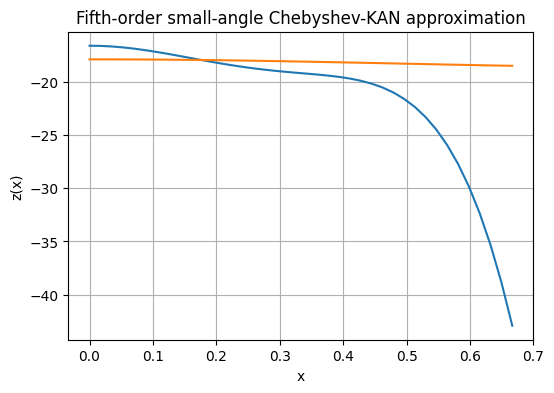

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Coefficients up to x^5
coeffs = np.array([
    -16.566252,   # p0
     0.169344,    # p1
   -64.276420,    # p2
    58.083328,    # p3
   457.515824,    # p4
  -801.160494     # p5
])

# Polynomial evaluation function
def z_approx(x, c):
    # Horner's rule for efficiency
    result = 0.0
    for coef in reversed(c):
        result = result * x + coef
    return result

# Domain 0 < x < 0.2
x_vals = np.linspace(0.0, 0.2, 40) / 0.3
z_vals = z_approx(x_vals, coeffs)


# Plotting
plt.figure(figsize=(6, 4))
plt.plot(x_vals, z_vals)
plt.plot(x_vals, models_infr([0]).reshape(200, 200, 1)[:40, 20, 0])
plt.title("Fifth-order small-angle Chebyshev-KAN approximation")
plt.xlabel("x")
plt.ylabel("z(x)")
plt.grid(True)
plt.show()


(9, 2, 4, 6) (1, 2, 4, 0) [2] [2]
c [] d []
(9, 2, 4, 6) (1, 2, 4, 1) [2] [2]
c [[[[-0.0699448 ]
   [ 0.02293275]
   [ 0.04919959]
   [ 0.01719464]]

  [[-0.20932725]
   [-0.02539442]
   [ 0.21853288]
   [-0.05313112]]]] d [[[[-0.8505256 ]]

  [[-0.7837597 ]]

  [[-0.73374605]]

  [[-0.8171512 ]]]]
(9, 2, 4, 6) (1, 2, 4, 2) [2] [2]
c [[[[-0.0699448  -0.11957631]
   [ 0.02293275  0.16836119]
   [ 0.04919959 -0.09103608]
   [ 0.01719464  0.17916398]]

  [[-0.20932725 -0.05121543]
   [-0.02539442  0.02646047]
   [ 0.21853288  0.01045209]
   [-0.05313112  0.08186758]]]] d [[[[-0.8505256   1.6566033 ]]

  [[-0.7837597   0.72082114]]

  [[-0.73374605 -2.8984292 ]]

  [[-0.8171512   0.7060524 ]]]]
(9, 2, 4, 6) (1, 2, 4, 3) [2] [2]
c [[[[-0.0699448  -0.11957631 -0.29860216]
   [ 0.02293275  0.16836119  0.31022173]
   [ 0.04919959 -0.09103608 -0.30091816]
   [ 0.01719464  0.17916398  0.13664919]]

  [[-0.20932725 -0.05121543  0.17945825]
   [-0.02539442  0.02646047 -0.0542903 ]
   [ 0.21853288 

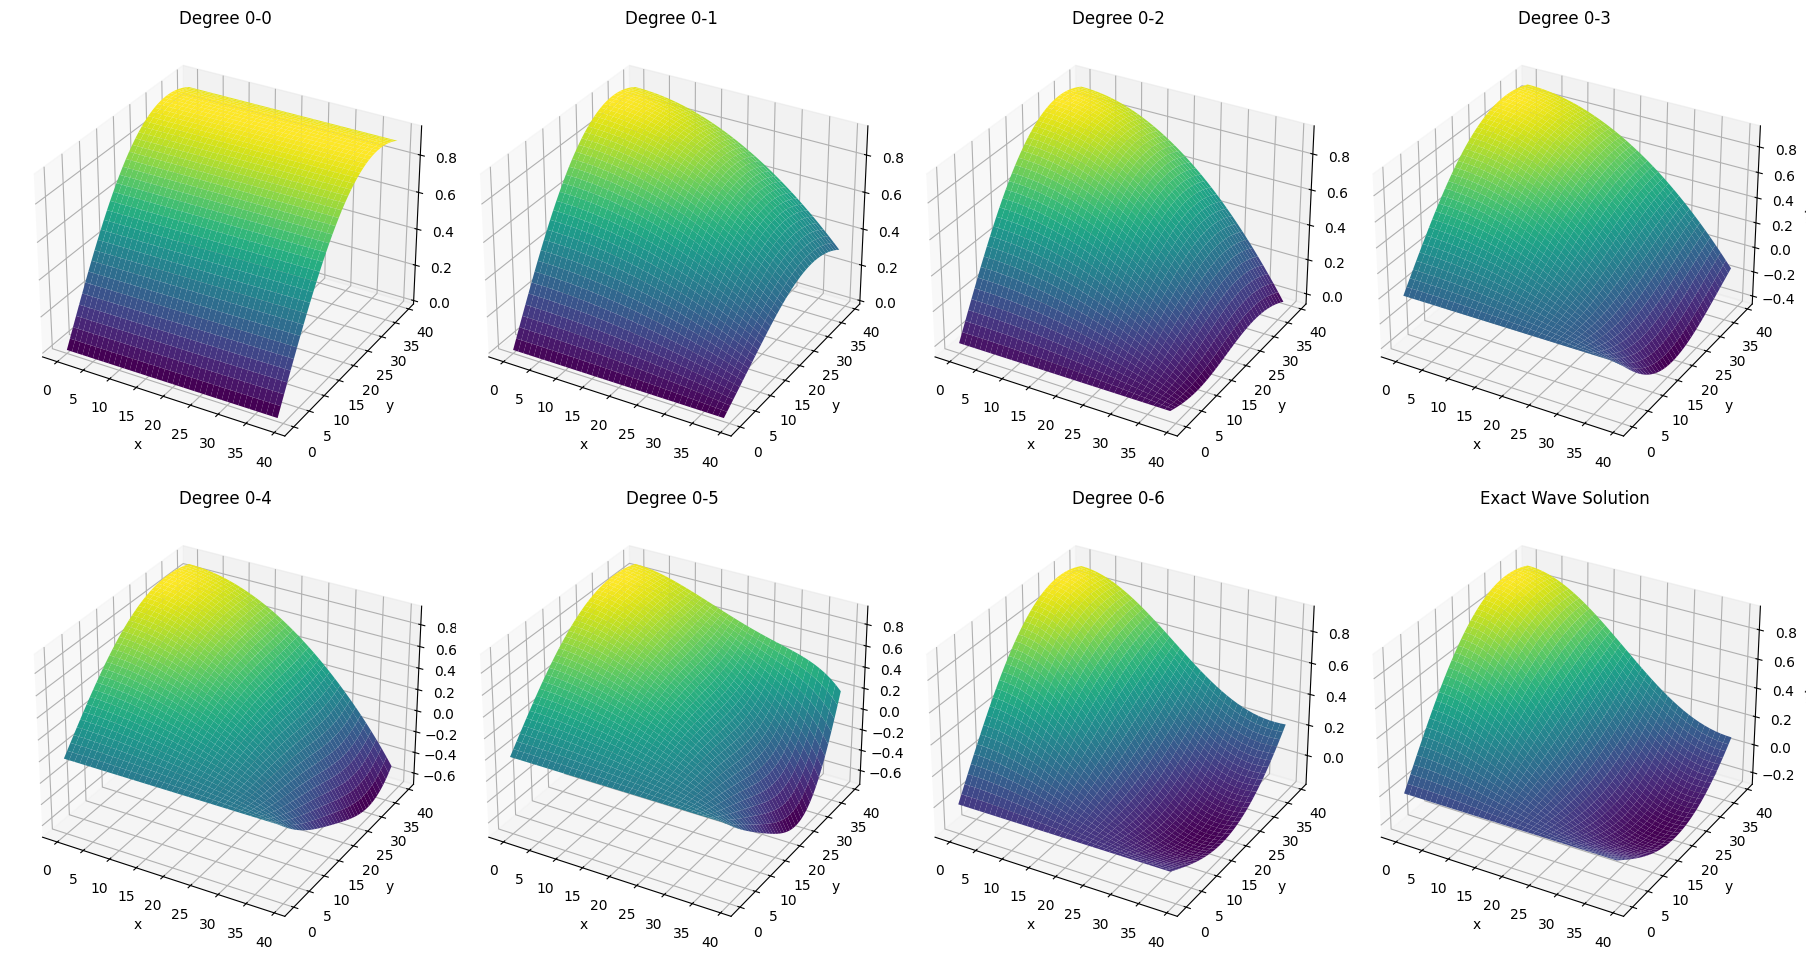

In [79]:
degs = 7
plt.figure(figsize=(18, 10))

for i in range(0, degs):
    ax = plt.subplot(2, 4, i+1, projection='3d')
    plot_sch(models_infr([0], degrees=(0, i)).reshape(200, 200, 1)[:40, :40, :].transpose(2, 0, 1), noshow=True, ax=ax)
    plt.title(f"Degree 0-{i}")

ax = plt.subplot(2, 4, degs+1, projection='3d')
plot_sch(exact_wave[:40, :40, :].transpose(2, 0, 1), noshow=True, ax=ax)
plt.title("Exact Wave Solution")

plt.tight_layout()
plt.show()

In [ ]:
def models_infr_single(models, degrees=(0,9), dims=(0, 1)):
    _, all_params, _, _, _ = load_model("/vol/bitbucket/ss7921/FBPINNs/benchmarks/notebooks/results/model_00020000.jax")

    a = all_params['trainable']['network']['subdomain']['coeffs']
    ka = all_params['static']['network']['subdomain']['kind']

    start_deg, end_deg = degrees
    start_dim, end_dim = dims

    c = a[models, :, start_dim:end_dim, start_deg:end_deg]
    kc = ka[models,]
    print(a.shape, c.shape)
    print(c)
    # print('c', c)

    changed_params = all_params.copy()
    changed_params['trainable']['network']['subdomain']['coeffs'] = (c)
    changed_params['static']['network']['subdomain']['kind'] = (kc)


    changed_params_cut = {"static":cut_all_(changed_params["static"]),
                    "trainable":cut_all_(changed_params["trainable"])}

    d = changed_params_cut
    changed_params_take = {t_k: {cl_k: {k: jax.tree_map(lambda p:p[m_take], d[t_k][cl_k][k]) if k=="subdomain" else d[t_k][cl_k][k]
            for k in d[t_k][cl_k]}
            for cl_k in d[t_k]}
            for t_k in ["static", "trainable"]}
    f = {t_k: {cl_k: {k: jax.tree_map(lambda p: 0, d[t_k][cl_k][k]) if k=="subdomain" else jax.tree_map(lambda p: None, d[t_k][cl_k][k])
            for k in d[t_k][cl_k]}
            for cl_k in d[t_k]}
            for t_k in ["static", "trainable"]}

    us, ws, uraw = vmap(foo, in_axes=(f,0,None, None, None, None))(changed_params_take, x_take, 
                                                                RectangularDecompositionND.norm_fn, 
                                                                ChebyshevKAN.network_fn, 
                                                                RectangularDecompositionND.unnorm_fn, 
                                                                RectangularDecompositionND.window_fn)

    u = jnp.concatenate([us, ws], axis=1)
    u = jax.ops.segment_sum(u, p_take, indices_are_sorted=False, num_segments=len(np_take))
    wp = u[:,-1:]
    u = u[:,:-1]/wp
    u = jax.ops.segment_sum(u, np_take, indices_are_sorted=False, num_segments=len(x_batch_test))
    # u = u/npou
    # u = WaveEquation2D.constraining_fn(all_params, x_batch_test, u)
    return u

models_infr_single([0]).shape

(9, 2, 1, 9) (1, 2, 1, 9)
[[[[-5.0933676  -2.4467304   3.964189    0.01318741 -0.5788006
     1.6458714  -2.1849368   0.6380522  -0.5469932 ]]

  [[-4.839332   -3.13062    -4.1066     -7.933879   -8.454842
    -5.0635095  -5.656488   -2.01734    -3.8160517 ]]]]
unnorm Traced<ShapedArray(float32[])>with<BatchTrace> with
  val = Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
  batch_dim = 0 Traced<ShapedArray(float32[])>with<BatchTrace> with
  val = Array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)
  batch_dim = 0


(40000, 1)

(9, 2, 1, 9) (1, 2, 1, 9)
[[[[-5.0933676  -2.4467304   3.964189    0.01318741 -0.5788006
     1.6458714  -2.1849368   0.6380522  -0.5469932 ]]

  [[-4.839332   -3.13062    -4.1066     -7.933879   -8.454842
    -5.0635095  -5.656488   -2.01734    -3.8160517 ]]]]


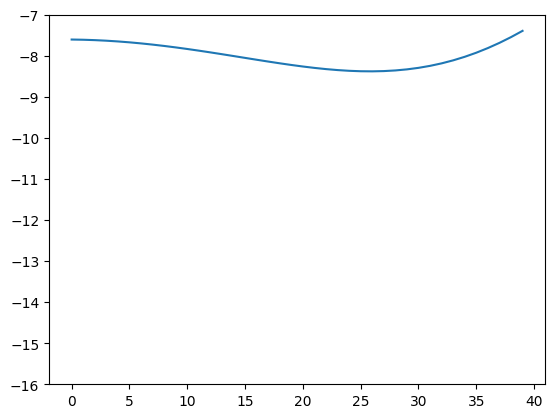

(9, 2, 1, 9) (1, 2, 1, 9)
[[[[-5.0933676  -2.4467304   3.964189    0.01318741 -0.5788006
     1.6458714  -2.1849368   0.6380522  -0.5469932 ]]

  [[-4.839332   -3.13062    -4.1066     -7.933879   -8.454842
    -5.0635095  -5.656488   -2.01734    -3.8160517 ]]]]


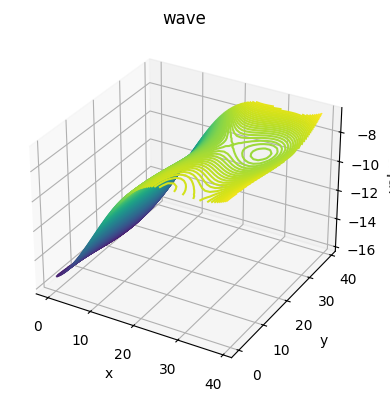

In [43]:
plt.plot(models_infr_single([0]).reshape(200, 200, 1)[:40, 20, 0])
plt.ylim((-16, -7))

plt.show()
plot_sch(models_infr_single([0]).reshape(200, 200, 1)[:40, :40, :].transpose(2, 0, 1))


(9, 2, 1, 9) (1, 2, 1, 9)
[[[[-5.0933676  -2.4467304   3.964189    0.01318741 -0.5788006
     1.6458714  -2.1849368   0.6380522  -0.5469932 ]]

  [[-4.839332   -3.13062    -4.1066     -7.933879   -8.454842
    -5.0635095  -5.656488   -2.01734    -3.8160517 ]]]]

            8             7             6             5        4
2.141e+06 x - 1.646e+06 x + 4.485e+05 x - 5.746e+04 x + 5996 x
          3         2
 - 87.66 x - 82.38 x - 0.5734 x - 7.605


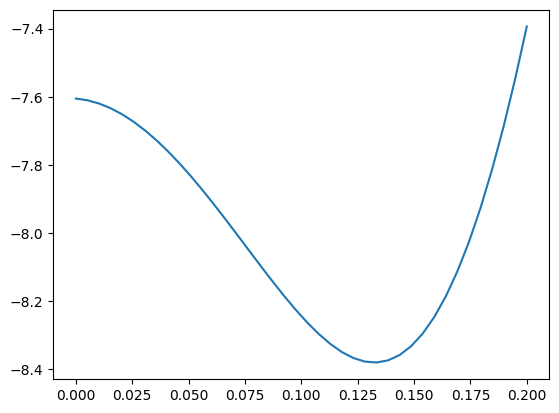

In [44]:
m = models_infr_single([0]).reshape(200, 200, 1)[:40, 20, 0]
xs = np.linspace(0, 1, 40)*0.2
poly = np.polyfit(xs, m, 8)
f = np.poly1d(poly)
print('\n', f)
plt.plot(xs, m, label='data')
# plt.plot(xs, f(xs), label='polyfit')

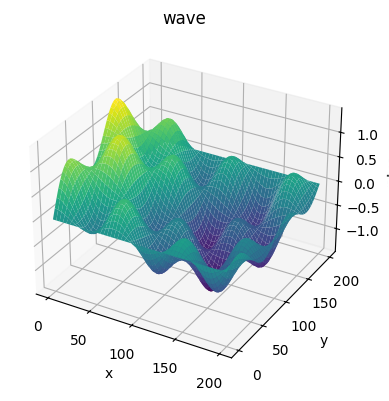

<Figure size 640x480 with 0 Axes>

In [89]:
plot_sch(exact_wave.transpose(2, 0, 1))
plt.tight_layout()
plt.show()

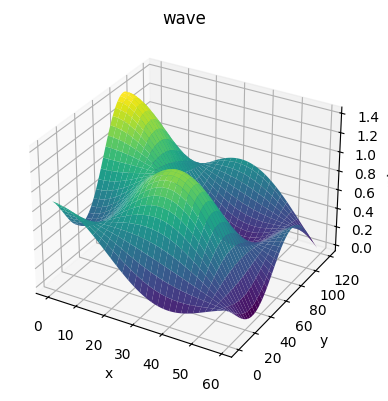

<Figure size 640x480 with 0 Axes>

In [88]:
plot_sch(exact_wave[40:160, :60, :].transpose(2, 0, 1))
plt.tight_layout()
plt.show()

(9, 2, 4, 6) (3, 2, 4, 6) [2 2 2] [2 2 2]
c [[[[-0.0699448  -0.11957631 -0.29860216 -0.11568612 -0.0546978
    -0.03104024]
   [ 0.02293275  0.16836119  0.31022173  0.18817611 -0.03811791
     0.0727372 ]
   [ 0.04919959 -0.09103608 -0.30091816 -0.18951927  0.04036855
    -0.09546851]
   [ 0.01719464  0.17916398  0.13664919  0.03199784  0.13729925
    -0.04029236]]

  [[-0.20932725 -0.05121543  0.17945825 -0.097971   -0.04495228
    -0.1333692 ]
   [-0.02539442  0.02646047 -0.0542903  -0.03326709 -0.05862406
     0.18162206]
   [ 0.21853288  0.01045209 -0.00503394 -0.0742318   0.06421527
     0.07485833]
   [-0.05313112  0.08186758 -0.07705869 -0.4733061   0.0127183
    -0.3042013 ]]]


 [[[-0.14031045 -0.11860887 -0.12262791 -0.01444275 -0.04307955
     0.03313349]
   [-0.04756426 -0.12620734 -0.1262194  -0.10024506  0.0280824
    -0.01784989]
   [-0.0039976   0.00942361  0.23901625  0.00187021  0.04720419
    -0.00749166]
   [ 0.13300815  0.0378488  -0.25524166  0.06456689 -0.0736654

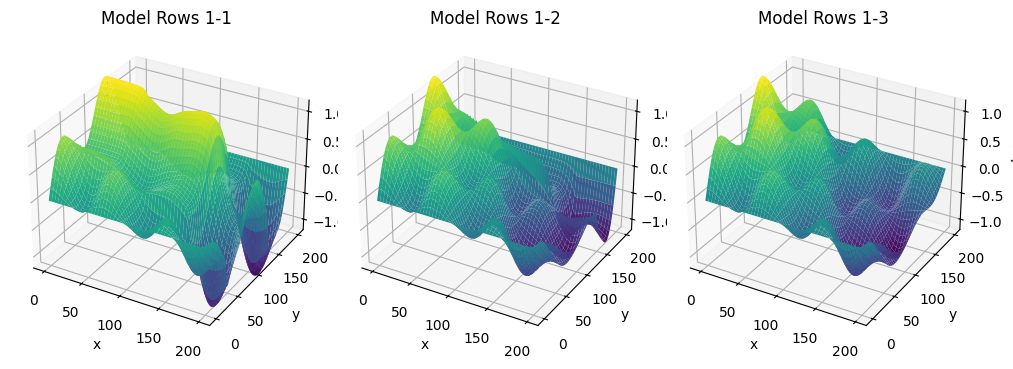

In [83]:
models = 3
plt.figure(figsize=(10, 20))

for i in range(1, models+1):
    ax = plt.subplot(3, 3, i, projection='3d')
    plot_sch(models_infr(models=np.arange(3*i)).reshape(200, 200, 1).transpose(2, 0, 1), noshow=True, ax=ax)
    ax.set_zlim(-1.2, 1.2)
    plt.title(f"Model Rows 1-{i}")

# ax = plt.subplot(3, 3, models, projection='3d')
# plot_sch(exact_wave.transpose(2, 0, 1), noshow=True, ax=ax)
# plt.title("Exact Wave Solution")

plt.tight_layout()
plt.show()
# plot_sch(models_infr([0]).reshape(200, 200, 1).transpose(2, 0, 1))
# plt.tight_layout()
# plt.show()

[[0, 60], [0, 60]]
(9, 2, 4, 6) (1, 2, 4, 6) [2] [2]
c [[[[-0.14031045 -0.11860887 -0.12262791 -0.01444275 -0.04307955
     0.03313349]
   [-0.04756426 -0.12620734 -0.1262194  -0.10024506  0.0280824
    -0.01784989]
   [-0.0039976   0.00942361  0.23901625  0.00187021  0.04720419
    -0.00749166]
   [ 0.13300815  0.0378488  -0.25524166  0.06456689 -0.07366543
     0.03464189]]

  [[-0.07829995 -0.07323178  0.29000944 -0.34757432  0.13386449
    -0.1504878 ]
   [-0.02524286  0.17092304 -0.16613765  0.12280954 -0.0842385
     0.08551162]
   [ 0.10957064  0.19608493 -0.09170653 -0.01524982  0.13922165
     0.05434598]
   [-0.04604058 -0.01946353 -0.22421156  0.379405   -0.17333792
     0.13421664]]]] d [[[[-0.05205856  0.05349259  0.13887674 -0.03403978 -0.4036058
     0.14129521]]

  [[-0.08434514  0.05959585  0.13931635 -0.12963656 -0.13684273
     0.21214584]]

  [[-0.10639115  0.04199931 -0.07469811  0.00446206  0.40122256
     0.06065685]]

  [[-0.11807797 -0.23713875  0.17027211  0.3

(9, 2, 4, 6) (1, 2, 4, 6) [2] [2]
c [[[[ 0.10176257  0.08744851  0.08744103  0.14392598  0.05946194
     0.10435319]
   [ 0.05646914 -0.13594852 -0.03128168 -0.08242948  0.00776041
    -0.00122529]
   [ 0.01975192  0.05225429 -0.04520231  0.12003241 -0.09604531
     0.05135124]
   [-0.07823473  0.03024979  0.16416365  0.006245   -0.00372425
    -0.00600182]]

  [[-0.03346125  0.1921799  -0.06711922 -0.07829097  0.20386462
    -0.15896091]
   [-0.00758403 -0.16319817  0.15641211 -0.01019657  0.00812705
     0.02507979]
   [-0.08450524 -0.00368519  0.07685571 -0.28637925 -0.01098323
    -0.1433473 ]
   [ 0.0122448  -0.10723988 -0.01576606  0.02460448 -0.08013091
    -0.07058674]]]] d [[[[ 0.00833664 -0.0170966   0.04706087 -0.0253914  -0.00152913
    -0.00721515]]

  [[ 0.00188626  0.00046088 -0.03141502  0.01795959 -0.06584578
    -0.10345177]]

  [[-0.12443326  0.07211746 -0.02375807  0.00528848 -0.07534159
     0.0539476 ]]

  [[-0.02935309 -0.00301644  0.03642928  0.10258789 -0.08657

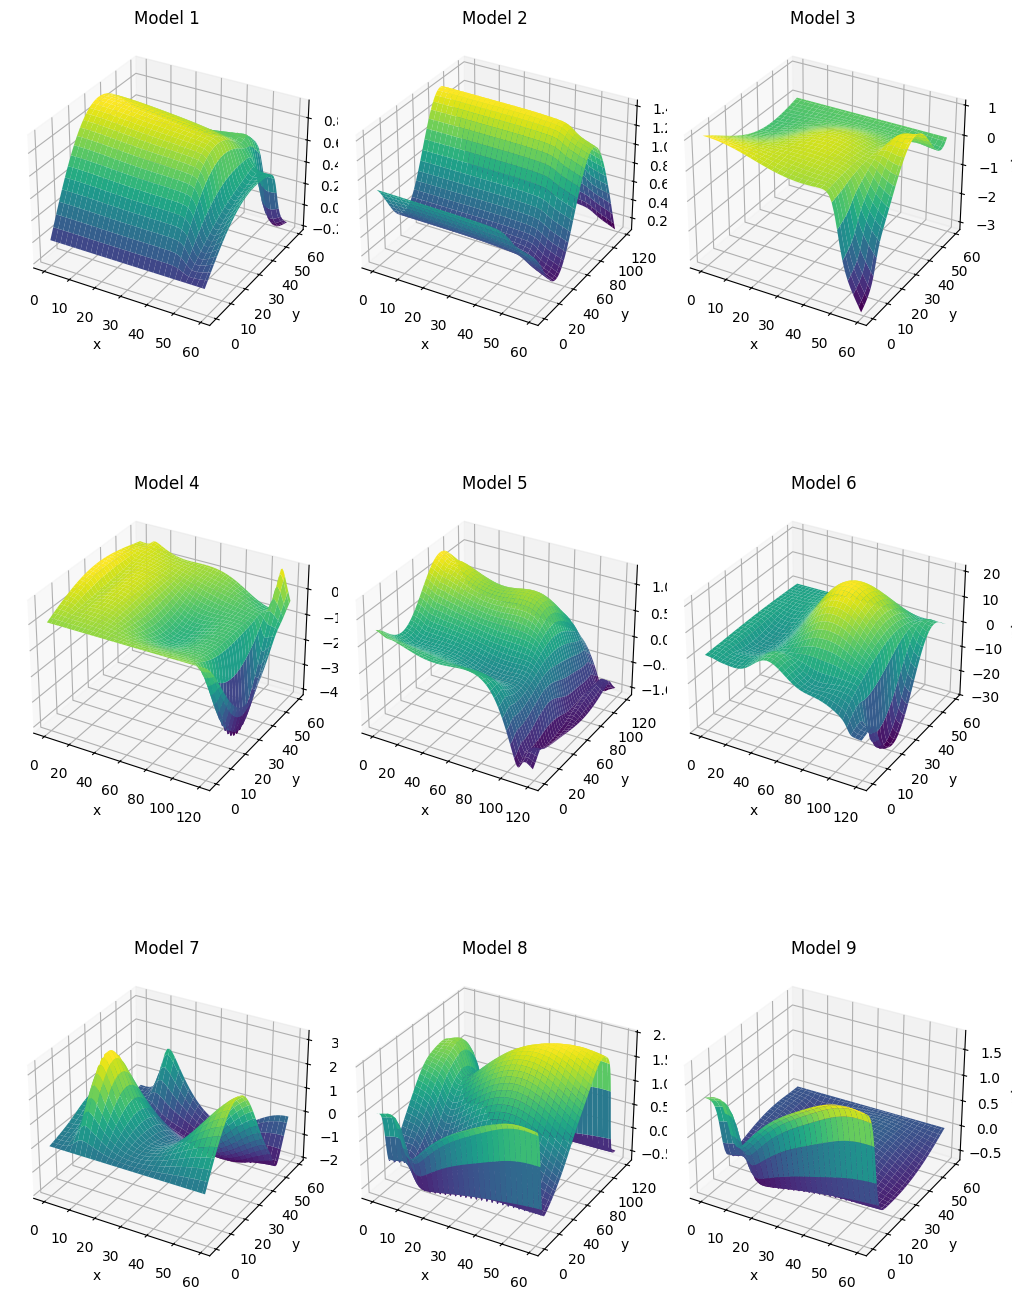

In [92]:
sections = [
    [[0, 60], [0, 60]],
    [[40, 160], [0, 60]],
    [[140, 200], [0, 60]],
    [[0, 60], [40, 160]],
    [[40, 160], [40, 160]],
    [[140, 200], [40, 160]],
    [[0, 60], [140, 200]],
    [[40, 160], [140, 200]],
    [[140, 200], [140, 200]]
]

models = 9
plt.figure(figsize=(10, 15))

for i in range(1, models+1):
    ax = plt.subplot(3, 3, i, projection='3d')
    section = sections[i-1]
    x_start, x_end = section[0]
    y_start, y_end = section[1]
    print(section)
    plot_sch(models_infr(models=[i]).reshape(200, 200, 1)[x_start:x_end, y_start:y_end, :].transpose(2, 0, 1), noshow=True, ax=ax)
    plt.title(f"Model {i}")

plt.tight_layout()
plt.show()